# IMPORTS

In [28]:
import tensorflow as tf
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import f1_score
import json
from google.colab import runtime
from google.colab import drive
drive.mount('/content/drive')
import gc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EVALUATION FUNCTIONS

In [2]:
def customPredict(yPred, thresholds):
    predictions = np.zeros_like(yPred)
    for i in thresholds.keys():
        threshold = thresholds[i]
        predictions[:, i] = (yPred[:, i] >= threshold).astype(int)
    predictions = np.argmax(predictions * yPred, axis=1)
    return predictions

def evaluateTensorflowModelBestThresholds(model, testDataset, thresholds, categories):
    test_labels = []
    for xBatch, yBatch in testDataset:
        test_labels.extend(np.argmax(yBatch, axis=1))
    predictions = customPredict(model.predict(testDataset), thresholds)

    report = classification_report(test_labels, predictions, target_names=categories)
    print(report)
    return test_labels, predictions

def evaluateTensorflowModel(model, testDataset, categories):

    test_labels = []
    for xBatch, yBatch in testDataset:
        test_labels.extend(np.argmax(yBatch, axis=1))
    predictions = np.argmax(model.predict(testDataset), axis=1)

    report = classification_report(test_labels, predictions, target_names=categories)
    print(report)
    return test_labels, predictions


# DATASET

In [3]:
batch_size = 1
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
categories = ["Normal","Osteopenia", "Osteoporosis"]
TfDatasetsPath = '/content/drive/MyDrive/CSEN-240-Project/TfDatasetsFull'

valDataset = tf.data.Dataset.load(TfDatasetsPath + "/validDataset")
testDataset = tf.data.Dataset.load(TfDatasetsPath + "/testDataset")

valDataset = valDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
testDataset = testDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# TESTING

In [4]:
thresholdsPath = '/content/drive/MyDrive/CSEN-240-Project/Thresholds/'
kerasModelsPath = '/content/drive/MyDrive/CSEN-240-Project/KerasModels/'

# Xception (0.93/0.95/0.90)

In [5]:
modelName = "Xception"
model = tf.keras.models.load_model(kerasModelsPath + modelName + ".keras")

In [6]:
thresholdsFile = thresholdsPath + modelName + ".json"
with open(thresholdsFile, 'r') as f:
    thresholds = json.load(f)
    thresholds = {int(k): v for k, v in thresholds.items()}
thresholds

{0: 0.6633543372154236, 1: 0.24547046422958374, 2: 0.7661489248275757}

In [7]:
labels, preds = evaluateTensorflowModel(model, testDataset, categories)

540/540 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step
              precision    recall  f1-score   support

      Normal       0.90      0.95      0.93       180
  Osteopenia       0.96      0.92      0.94       180
Osteoporosis       0.91      0.90      0.91       180

    accuracy                           0.92       540
   macro avg       0.92      0.92      0.92       540
weighted avg       0.92      0.92      0.92       540



In [8]:
labels, preds = evaluateTensorflowModelBestThresholds(model, testDataset,thresholds, categories)

540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
              precision    recall  f1-score   support

      Normal       0.89      0.98      0.93       180
  Osteopenia       0.95      0.96      0.95       180
Osteoporosis       0.96      0.84      0.90       180

    accuracy                           0.93       540
   macro avg       0.93      0.93      0.93       540
weighted avg       0.93      0.93      0.93       540



Text(95.72222222222221, 0.5, 'True Label')

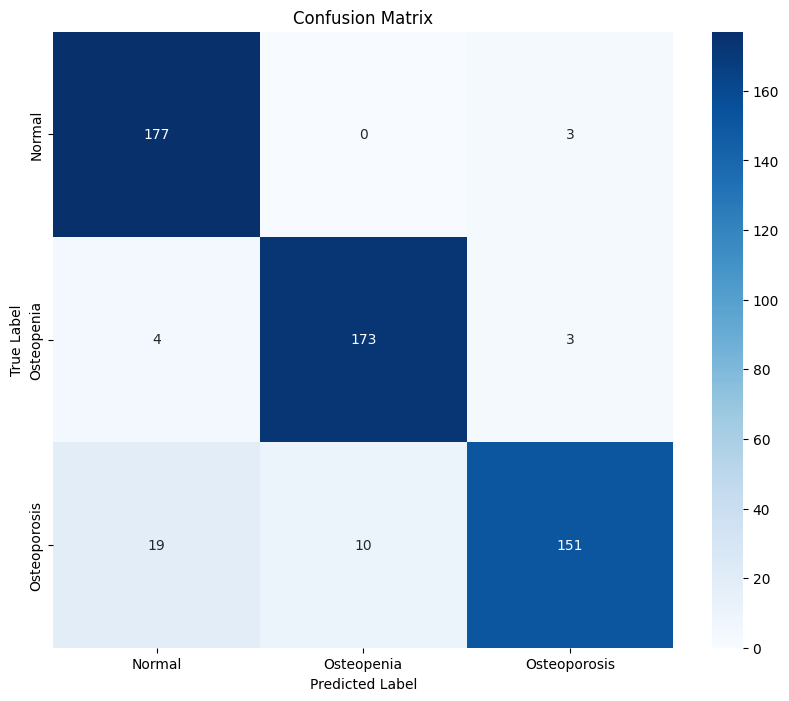

In [9]:
confusion = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# VGG16 (0.92/0.94/0.87)

In [10]:
modelName = "VGG16"
model = tf.keras.models.load_model(kerasModelsPath + modelName + ".keras")

In [11]:
thresholdsFile = thresholdsPath + modelName + ".json"
with open(thresholdsFile, 'r') as f:
    thresholds = json.load(f)
    thresholds = {int(k): v for k, v in thresholds.items()}
thresholds

{0: 0.5541611909866333, 1: 0.1951954960823059, 2: 0.6709107756614685}

In [12]:
labels, preds = evaluateTensorflowModel(model, testDataset, categories)

540/540 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
              precision    recall  f1-score   support

      Normal       0.90      0.93      0.92       180
  Osteopenia       0.95      0.90      0.93       180
Osteoporosis       0.86      0.88      0.87       180

    accuracy                           0.90       540
   macro avg       0.90      0.90      0.90       540
weighted avg       0.90      0.90      0.90       540



In [13]:
labels, preds = evaluateTensorflowModelBestThresholds(model, testDataset, thresholds, categories)

540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

      Normal       0.88      0.96      0.92       180
  Osteopenia       0.94      0.93      0.94       180
Osteoporosis       0.90      0.84      0.87       180

    accuracy                           0.91       540
   macro avg       0.91      0.91      0.91       540
weighted avg       0.91      0.91      0.91       540



Text(95.72222222222221, 0.5, 'True Label')

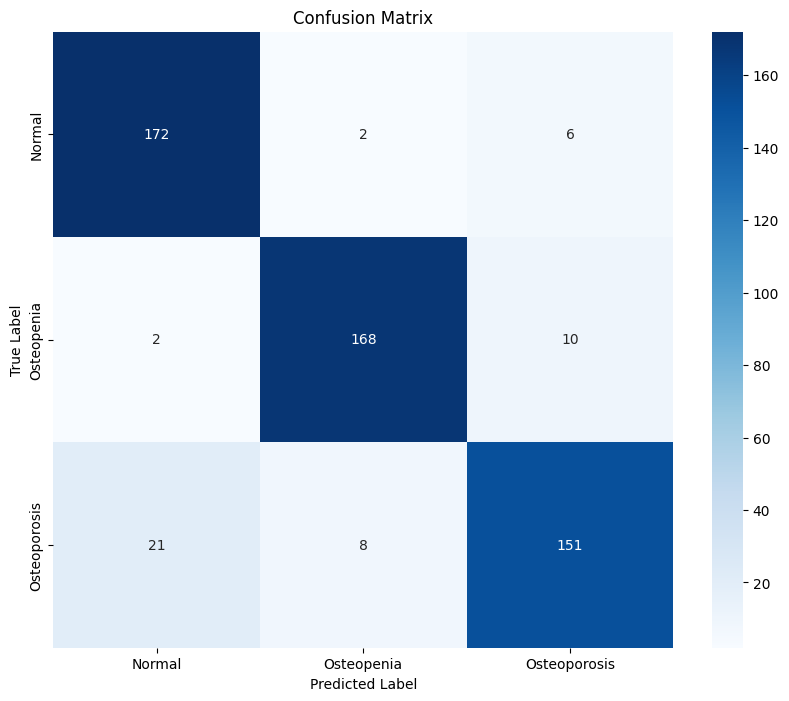

In [14]:
confusion = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# DenseNet201 (0.94/0.96/0.92)

In [15]:
modelName = "DenseNet201"
model = tf.keras.models.load_model(kerasModelsPath + modelName + ".keras")

In [16]:
thresholdsFile = thresholdsPath + modelName + ".json"
with open(thresholdsFile, 'r') as f:
    thresholds = json.load(f)
    thresholds = {int(k): v for k, v in thresholds.items()}
thresholds

{0: 0.5775161385536194, 1: 0.2761756181716919, 2: 0.5903303623199463}

In [17]:
labels, preds = evaluateTensorflowModel(model, testDataset, categories)

540/540 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step
              precision    recall  f1-score   support

      Normal       0.90      0.96      0.93       180
  Osteopenia       0.97      0.91      0.94       180
Osteoporosis       0.92      0.92      0.92       180

    accuracy                           0.93       540
   macro avg       0.93      0.93      0.93       540
weighted avg       0.93      0.93      0.93       540



In [18]:
labels, preds = evaluateTensorflowModelBestThresholds(model, testDataset, thresholds, categories)

540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       180
  Osteopenia       0.97      0.94      0.96       180
Osteoporosis       0.94      0.90      0.92       180

    accuracy                           0.94       540
   macro avg       0.94      0.94      0.94       540
weighted avg       0.94      0.94      0.94       540



Text(95.72222222222221, 0.5, 'True Label')

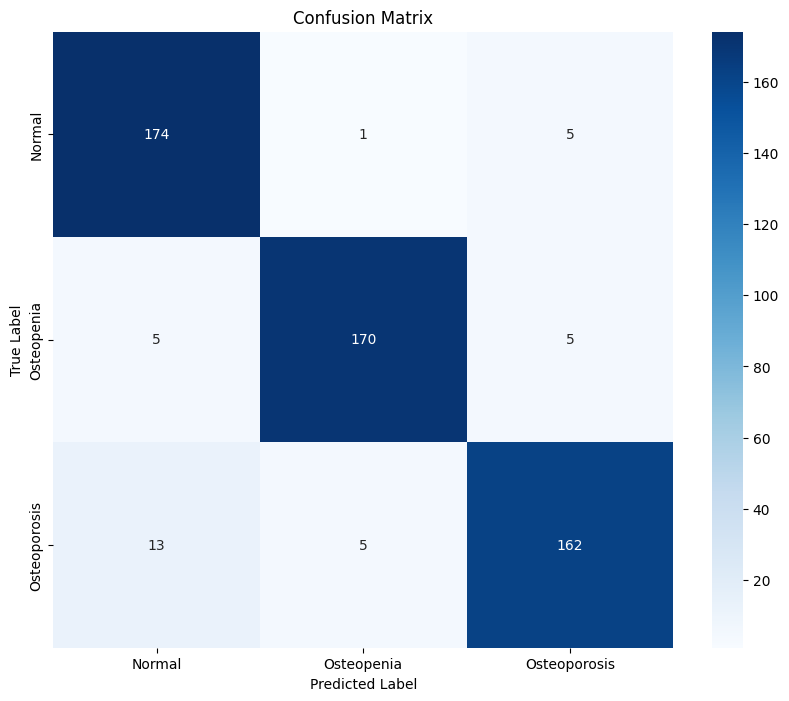

In [19]:
confusion = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# InceptionResNetV2 (0.92/0.96/0.89)

In [20]:
modelName = "InceptionResNetV2"
model = tf.keras.models.load_model(kerasModelsPath + modelName + ".keras")

In [21]:
thresholdsFile = thresholdsPath + modelName + ".json"
with open(thresholdsFile, 'r') as f:
    thresholds = json.load(f)
    thresholds = {int(k): v for k, v in thresholds.items()}
thresholds

{0: 0.8146647810935974, 1: 0.11155779659748077, 2: 0.790868878364563}

In [22]:
labels, preds = evaluateTensorflowModel(model, testDataset, categories)

540/540 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step
              precision    recall  f1-score   support

      Normal       0.90      0.95      0.92       180
  Osteopenia       0.96      0.89      0.92       180
Osteoporosis       0.89      0.90      0.90       180

    accuracy                           0.91       540
   macro avg       0.91      0.91      0.91       540
weighted avg       0.91      0.91      0.91       540



In [23]:
labels, preds = evaluateTensorflowModelBestThresholds(model, testDataset, thresholds, categories)

540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
              precision    recall  f1-score   support

      Normal       0.88      0.96      0.92       180
  Osteopenia       0.95      0.97      0.96       180
Osteoporosis       0.95      0.84      0.89       180

    accuracy                           0.92       540
   macro avg       0.93      0.92      0.92       540
weighted avg       0.93      0.92      0.92       540



Text(95.72222222222221, 0.5, 'True Label')

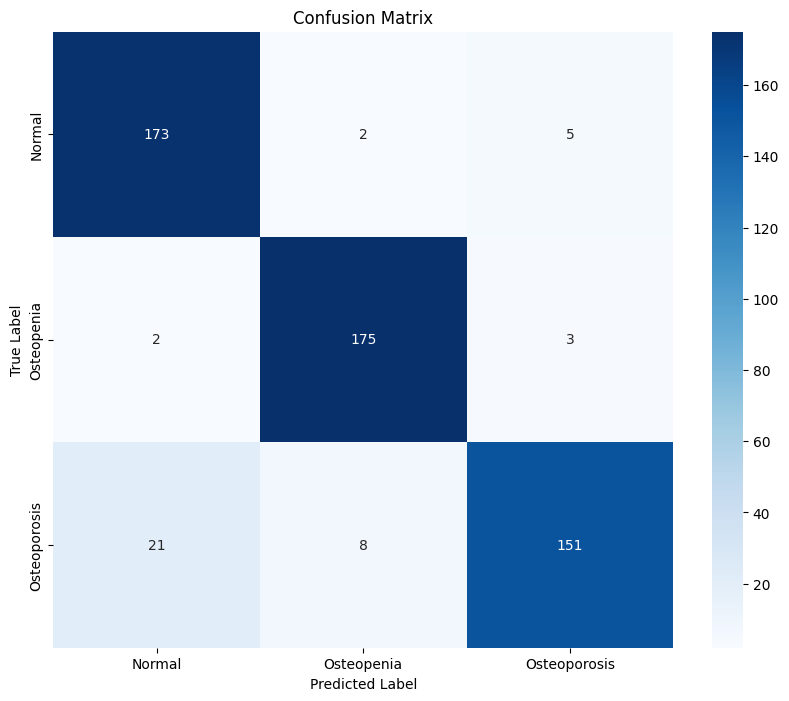

In [24]:
confusion = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# VotingEnsemble (0.95/0.97/0.93)

In [25]:
modelNames = ['InceptionResNetV2.keras',
  'DenseNet201.keras',
  'VGG16.keras',
  'Xception.keras']

In [29]:
def ensembleModels(predictedClasses):
    votedPredictions = []
    numModels = len(predictedClasses)
    samples = len(predictedClasses[0])
    for i in range(samples):
        count0, count1, count2 = 0, 0, 0
        for j in range(numModels):
            if predictedClasses[j][i] == 0:
                count0 += 1
            elif predictedClasses[j][i] == 1:
                count1 += 1
            else:
                count2 += 1
        if count0 > count1 and count0 > count2:
            votedPredictions.append(0)
        elif count1 > count0 and count1 > count2:
            votedPredictions.append(1)
        else:
            votedPredictions.append(2)
    return votedPredictions

def customPredict(yPred, thresholds):
    predictions = np.zeros_like(yPred)
    for i in thresholds.keys():
        threshold = thresholds[i]
        predictions[:, i] = (yPred[:, i] >= threshold).astype(int)
    predictions = np.argmax(predictions * yPred, axis=1)
    return predictions

def predict(modelNames, testDataset):
    predictedClasses = []
    for modelName in modelNames:
        name = modelName.split('.')[0]
        modelPath = kerasModelsPath + modelName
        model = tf.keras.models.load_model(modelPath)
        predictions = model.predict(testDataset)
        thresholdPath = thresholdsPath + name + '.json'
        with open(thresholdPath, 'r') as f:
            threshold = json.load(f)
            threshold = {int(k): v for k, v in threshold.items()}
        predicted = customPredict(predictions, threshold)
        predictedClasses.append(predicted)
        tf.keras.backend.clear_session()
        del model
        gc.collect()
    return ensembleModels(predictedClasses)

In [30]:
yTrue = []
for xBatch, yBatch in testDataset:
    yTrue.extend(np.argmax(yBatch.numpy(), axis=1))

yPred = predict(modelNames, testDataset)

report = classification_report(yTrue, yPred, target_names=categories)
print(report)

540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step
540/540 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
              precision    recall  f1-score   support

      Normal       0.94      0.97      0.95       180
  Osteopenia       0.97      0.96      0.97       180
Osteoporosis       0.94      0.92      0.93       180

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540



Text(95.72222222222221, 0.5, 'True Label')

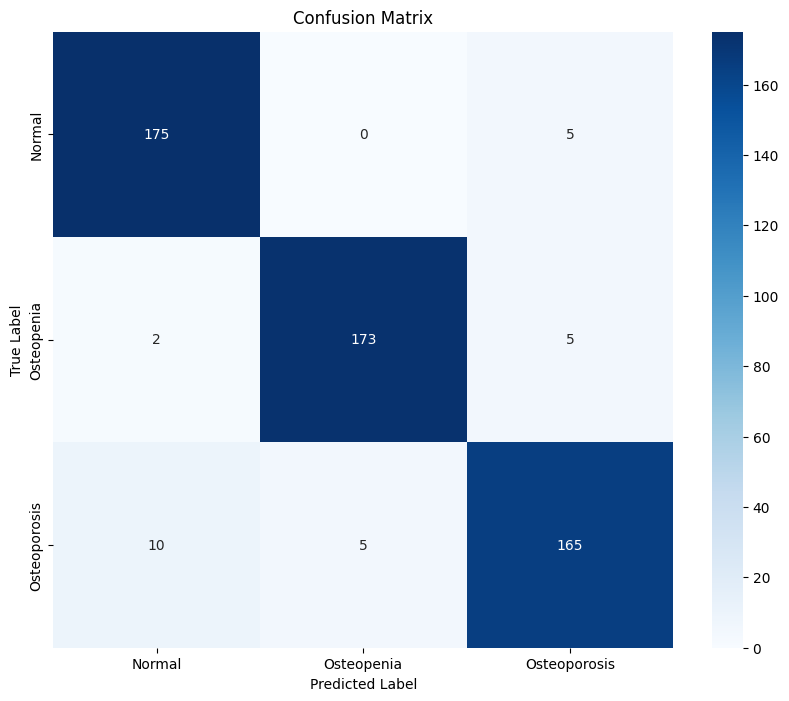

In [31]:
confusion = confusion_matrix(yTrue, yPred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [32]:
runtime.unassign()